In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# pd.options.display.max_columns
pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_columns",20)
pd.set_option('float_format', '{:.3f}'.format)

## Read the data in pandas

In [2]:
# Load Usage data
with open('App_usage_trace.txt') as f:
    lines = f.readlines()#[:100000]
    df = []
    for line in lines:
        data = line.split()
        df.append(data)
usage = pd.DataFrame(df, columns=['uid','timestamp', 'loc', 'app_id','traffic'])
usage['traffic'] = usage['traffic'].astype('float64') / 1e6 # Convert traffic to MB
usage['timestamp'] = usage['timestamp'].apply(lambda x: datetime.strptime(x, "%Y%m%d%H%M%S")) # Convert to datetime object
usage['loc'] = usage['loc'].astype('int64')

# Load App2Category data
with open('App2Category.txt') as f:
    lines = f.readlines()
    df = []
    for line in lines:
        data = line.split()
        df.append(data)
app2cat = pd.DataFrame(df, columns=['app_id','cat_id'])

# Load base station POI data
base_poi = pd.read_csv("base_poi.txt", delimiter='\t')

# Load Category dictionary
cat = pd.read_csv("Categorys.txt", delimiter='\t', header = None)
cat.columns = ['cat_id','category']
cat.set_index('cat_id', inplace=True)


print("< ---- Basic information ---- >")
print("- {} base stations. {} entries".format(base_poi.shape[0], usage.shape[0]))
print()
print("< ---- Unique users ---- >")
print("- {} unique users".format(len(usage['uid'].unique())))



< ---- Basic information ---- >
- 9851 base stations. 4171950 entries

< ---- Unique users ---- >
- 871 unique users


## App-App insights
1. App type distribution
2. App to next App
    2. Set of 2, 3, App
    3. Segregate in different period of the day


### 1. App Switching behavior

In [14]:
# If the next entry is a different app
# Store the combination
def app_set(df):
    app_set = []
    record = {}
    
    # Iterate through the dataset
    for i in range(df.shape[0]):
        
        # Get the first app
        first = df['app_id'].iloc[i]
        # Get the next app used except last row
        try:
            second = df['app_id'].iloc[i+1]
        except:
            print("reach last entry")
            pass
        
        # print(second)
        if first != second:
                    
            # Ensure the user open the app within certain time
            first_time = df['timestamp'].iloc[i]
            try: second_time = df['timestamp'].iloc[i+1]
            except: pass
            time_diff = second_time - first_time
            
            if time_diff < timedelta(minutes=3):
                if (first, second) not in app_set:
                    app_set.append((first, second))
                    record[(first, second)] = 0
                else:
                    record[(first, second)] +=1

    # Sort the record
    record = {k: v for k,v in sorted(record.items(), key=lambda item: item[1], reverse=True)}
    app_set = set(app_set)
    return app_set, record

In [3]:
# # Get a list of unique users
# unique_users = usage['uid'].unique()

# # Create the dictionary to record the appset and set appearance
# app_app_per_user = {}
# app_app_per_user['uid'] = []
# app_app_per_user['app_set'] = []
# app_app_per_user['combo_record'] = []

# for i in unique_users:
#     # Filter a dataset for that unique user
#     user_usage = usage[usage['uid'] == i]
#     appset, record = app_set(user_usage)
#     app_app_per_user['uid'].append(i)
#     app_app_per_user['app_set'].append(appset)
#     app_app_per_user['combo_record'].append(record)

# # Create df for easier operation
# user_app_app = pd.DataFrame(app_app_per_user)
# user_app_app.set_index('uid', inplace=True)

# def assign(x, n):
#     try: return list(x)[n]
#     except: return None

# # # Create the top 3 combo of each user
# for i in ['1','2','3']:
#     try:
#         user_app_app[i] = user_app_app['combo_record'].apply(lambda x: assign(x, int(i)-1))
#     except:
#         print(i, "Some users do not have top 3")

## The most popular app switch (App "Type - App "Type)
Based on the number of times a user swtiches app

In [119]:
def find_cat(i):
    x = app2cat[app2cat['app_id'] == i].iloc[0]['cat_id']
    return cat.iloc[int(x)-1]['category']

top_n_combo = 10

print('{:<65} | {:65} | {:5}'.format("App 1","App 2", "User out of {}".format(len(unique_users))))
print('-'*140)
top_3 = pd.concat([user_app_app['1'],user_app_app['2'], user_app_app['3']], axis=0, ignore_index=True)
top_3 = top_3.value_counts()
for i in range(top_n_combo):
    x = top_3.index[i]
    a = find_cat(x[0])
    b = find_cat(x[1])
    print('{:5}{:60} | {:5}{:60} |'.format(x[0], a, x[1], b, "i"), top_3.iloc[i])
    print('-'*140)


App 1                                                             | App 2                                                             | User out of 46
--------------------------------------------------------------------------------------------------------------------------------------------
488  'News'                                                       | 220  'News'                                                       | 13
--------------------------------------------------------------------------------------------------------------------------------------------
220  'News'                                                       | 488  'News'                                                       | 13
--------------------------------------------------------------------------------------------------------------------------------------------
18   'Social\_Networking'                                         | 55   'Social\_Networking'                                         | 9
----------

### Top 10 app category switch out of 871 users's top 3 app switching behavior

In [65]:
top_3 = top_3.reset_index()
top_3.columns = ['app_set', 'count']
top_3['cat_set'] = top_3['app_set'].apply(lambda x: (find_cat(str(x[0])), find_cat(str(x[1]))))

In [66]:
pd.pivot_table(top_3, index='cat_set', values='count', aggfunc='sum').sort_values('count', ascending=False).head(10)

,count
cat_set,
"('News', 'News')",51
"('Social\_Networking', 'Social\_Networking')",34
"('sports', 'sports')",11
"('sports', 'Social\_Networking')",8
"('Social\_Networking', 'sports')",6
"('Lifestyle ', 'sports')",4
"('sports', 'Navigation')",3
"('Travel', 'Travel')",3
"('Navigation', 'Social\_Networking')",2


## Save the user with app set to csv

In [67]:
user_app_app.to_csv("user_app_app.csv")

## Traffic in 15-minute interval

In [4]:
try:
    usage.set_index('timestamp', inplace=True)
except:
    print("Index has been set to timestamp")
    print(usage.head(3))

# To aggregate the time starting from 0800 to 15-min interval
traffic = usage.resample("30T").sum()


Taffic in 30-min interval
Min: 0.32 MB
Max: 590.97 MB
Avg: 201.60 MB


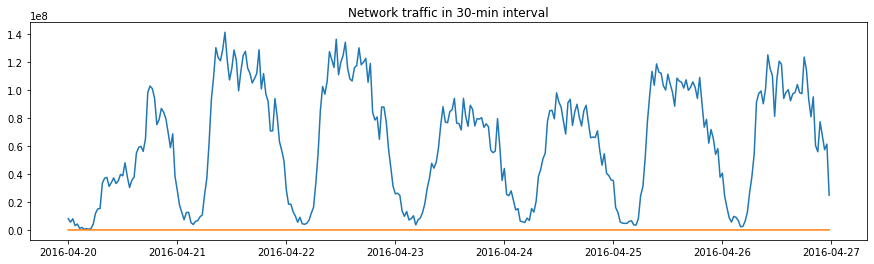

In [5]:
print("Taffic in 30-min interval")
print("Min: {:.2f} MB".format(traffic['traffic'].min()))
print("Max: {:.2f} MB".format(traffic['traffic'].max()))
print("Avg: {:.2f} MB".format(traffic['traffic'].mean()))
plt.figure(figsize=(15,4))
plt.plot(traffic)
plt.title("Network traffic in 30-min interval")
plt.show()

# Studying the area covered by the base station

## Identify the role of area

In [16]:
# Load base station POI data
base_poi = pd.read_csv("base_poi.txt", delimiter='\t')
base_poi.set_index('BaseID', inplace=True)

In [17]:
base_specific = base_poi.copy()

# Get the ratio of POI
base_specific['sum'] = base_specific.sum(axis=1)
for i in base_specific.columns[:-1]:
    base_specific[i] = base_specific[i] / base_specific['sum']


base_80 = base_specific[base_specific >= 0.8].drop('sum', axis=1)
print(base_80.count())
print()
print("Assuming an area with 80% same kind of POI is a functional neighbourhood")
print("We can identify {} out of {} areas (base stations)".format(base_80.count().sum(), base_poi.shape[0]))


Medical care                  12
Hotel                         12
Business affairs             249
Life service                   9
Transportation hub             5
Culture                        6
Sports                        17
Residence                    436
Entertainment and leisure      3
Scenic spot                   37
Government                    19
Factory                        5
Shopping                      23
Restaurant                    13
Education                     14
Landmark                      85
Other                         28
dtype: int64

Assuming an area with 80% same kind of POI is a functional neighbourhood
We can identify 973 out of 9851 areas (base stations)


In [18]:
# Remove BaseID that cannot be categorised
base_80_clean = base_80.dropna(how='all')

# Create a dict with spefici role and the BaseID
specific_area = {}
for i in base_80_clean.columns:
    specific_area[i] = base_80_clean[base_80_clean[i] == True].index.tolist()

In [19]:
roles = [str(x) for x in specific_area.keys()]
print(roles)

['Medical care', 'Hotel', 'Business affairs', 'Life service', 'Transportation hub', 'Culture', 'Sports', 'Residence', 'Entertainment and leisure', 'Scenic spot', 'Government', 'Factory', 'Shopping', 'Restaurant', 'Education', 'Landmark', 'Other']


In [20]:
## Number of records that we can explore in certain areas

In [21]:
for i in roles:

    n_entry = usage[usage['loc'].isin(specific_area[i])].shape[0]
    print("{:15}: {}".format(i.split()[0], n_entry))


Medical        : 1480
Hotel          : 4992
Business       : 48502
Life           : 2400
Transportation : 965
Culture        : 917
Sports         : 8724
Residence      : 93276
Entertainment  : 1842
Scenic         : 6471
Government     : 4354
Factory        : 2013
Shopping       : 4512
Restaurant     : 5448
Education      : 1144
Landmark       : 7691
Other          : 11730


In [22]:
def assign(x, n):
    try: return list(x)[n]
    except: return None

def find_cat(i):
    x = app2cat[app2cat['app_id'] == i].iloc[0]['cat_id']
    return cat.iloc[int(x)-1]['category']

def app_app_behavior(area):

    # Get a list of unique users
    unique_users = area['uid'].unique()

    # Count how many users with only 1 entry
    one_entry = 0

    # Create the dictionary to record the appset and set appearance
    app_app_per_user = {}
    app_app_per_user['uid'] = []
    app_app_per_user['app_set'] = []
    app_app_per_user['combo_record'] = []

    for i in unique_users:
        # Filter a dataset for that unique user
        user_usage = area[area['uid'] == i]
        if user_usage.shape[0] > 1:
            appset, record = app_set(user_usage)
            app_app_per_user['uid'].append(i)
            app_app_per_user['app_set'].append(appset)
            app_app_per_user['combo_record'].append(record)

            # Create df for easier operation
            user_app_app = pd.DataFrame(app_app_per_user)
            user_app_app.set_index('uid', inplace=True)
        
        else:
            one_entry += 1
    print("{} out of {} users has one record only.".format(one_entry, len(unique_users)))

    # # Create the top 3 combo of each user
    for i in ['1','2','3']:
        try:
            user_app_app[i] = user_app_app['combo_record'].apply(lambda x: assign(x, int(i)-1))
        except:
            print(i, "Some users do not have top 3")

    # Show only top 5 combo
    top_n_combo = 5

    # Create the top 3 combo summary
    top_3 = pd.concat([user_app_app['1'],user_app_app['2'], user_app_app['3']], axis=0, ignore_index=True)
    top_3 = top_3.value_counts()

    # print('{:<55} | {:55} | {:5}'.format("App 1","App 2", "User out of {}".format(len(unique_users))))
    # print('-'*140)
    # for i in range(top_n_combo):
    #     x = top_3.index[i]
    #     a = find_cat(x[0])
    #     b = find_cat(x[1])
    #     print('{:5}{:50} | {:5}{:50} |'.format(x[0], a, x[1], b, "i"), top_3.iloc[i])
    #     print('-'*140)

    top_3 = top_3.reset_index()
    top_3.columns = ['app_set', 'count']
    top_3['cat_set'] = top_3['app_set'].apply(lambda x: (find_cat(str(x[0])), find_cat(str(x[1]))))

    app_app_cat = pd.pivot_table(top_3, index='cat_set', values='count', aggfunc='sum').sort_values('count', ascending=False).head(10)
    print(app_app_cat)

## App switching behaviour in a categorized area

In [272]:
# for i in roles:

#     print(i)
#     print('-'*100)
#     print()
#     app_app_behavior(usage[usage['loc'].isin(specific_area[i])])
#     print()
#     print('-'*100)

The above results calculated by:
- Subset the app usage from a categorized base station area
- Identify the top 3 app switching pattern
- Aggregate by the app switch among all users 

In [43]:
user_entry = usage['uid'].value_counts()
pd.set_option('float_format', '{:.3f}'.format)
print(user_entry.describe())
print()
print("Over half of the users contain 1659 records in 7 days")

count       871.000
mean       4789.839
std       38407.519
min           4.000
25%         647.500
50%        1659.000
75%        3534.000
max     1098748.000
Name: uid, dtype: float64

Over half of the users contain 1659 records in 7 days


# Getting user daily behaviour
## Will document how I get this later

In [260]:
user_0 = usage[usage['uid'] == '190']
user_0.reset_index(inplace=True)
user_0['app_cat'] = user_0['app_id'].apply(lambda x: find_cat(x))
user_0['app_id_offset'] = user_0['app_id'].shift(1)
user_0_duration = user_0[user_0['app_id'] != user_0['app_id_offset']]

<ipython-input-260-745b6e5dd9d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_0['app_cat'] = user_0['app_id'].apply(lambda x: find_cat(x))
<ipython-input-260-745b6e5dd9d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_0['app_id_offset'] = user_0['app_id'].shift(1)


In [267]:
user_0 = usage[usage['uid'] == '888']
user_0.reset_index(inplace=True)
user_0['app_cat'] = user_0['app_id'].apply(lambda x: find_cat(x))
user_0['app_id_offset'] = user_0['app_id'].shift(1)
user_0_duration = user_0[user_0['app_id'] != user_0['app_id_offset']]

start = []
duration = []
app = []
app_id = []
location = []
traffic = []
for i in range(user_0_duration.shape[0]):
    entry = user_0_duration.iloc[i]
    app1_time = entry['timestamp']
    start.append(app1_time)
    try: duration.append(user_0_duration.iloc[i+1]['timestamp'] - app1_time)
    except: duration.append(app1_time - app1_time)
    app.append(entry['app_cat'])
    app_id.append(entry['app_id'])
    location.append(entry['loc'])

user_0_summary = pd.DataFrame({'start':start,'app':app,'app_id': app_id, 'delta':duration, 'loc':location, })

<ipython-input-267-1bb4e3a1d097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_0['app_cat'] = user_0['app_id'].apply(lambda x: find_cat(x))
<ipython-input-267-1bb4e3a1d097>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_0['app_id_offset'] = user_0['app_id'].shift(1)


In [271]:
user_0_summary[user_0_summary['start'] > datetime(2016,4,21,6)].iloc[100:150]


,start,app,app_id,delta,loc
157,2016-04-21 19:24:47,'Lifestyle ',770,0 days 00:06:09,3912
158,2016-04-21 19:30:56,'Lifestyle ',781,0 days 01:47:43,3912
159,2016-04-21 21:18:39,'Social\_Networking',1,0 days 00:16:26,3912
160,2016-04-21 21:35:05,'Entertainment',98,0 days 00:23:19,3912
161,2016-04-21 21:58:24,'sports',249,0 days 00:29:26,3910
162,2016-04-21 22:27:50,'sports',68,0 days 00:00:03,3910
163,2016-04-21 22:27:53,'Entertainment',755,0 days 08:30:07,3910
164,2016-04-22 06:58:00,'sports',42,0 days 00:49:04,6484
165,2016-04-22 07:47:04,'Social\_Networking',1,0 days 00:23:44,3912
166,2016-04-22 08:10:48,'Lifestyle ',33,0 days 00:13:34,661
